In [1]:
import gzip
import pickle

import numpy as np
from nilearn import image, masking, plotting
import matplotlib.pyplot as plt

In [2]:
def get_features(decoder):
    topic_word_weights = decoder.p_word_g_topic_
    n_topics = topic_word_weights.shape[1]
    vocabulary = np.array(decoder.vocabulary)
    sorted_weights_idxs = np.argsort(-topic_word_weights, axis=0)
    top_tokens = [
        "_".join(vocabulary[sorted_weights_idxs[:, topic_i]][:3])
        for topic_i in range(n_topics)
    ]
    features = [f"{i + 1}_{top_tokens[i]}" for i in range(n_topics)]
    return features

def gen_association(old_features, new_features):
    old_new_association = np.zeros((len(old_features), len(new_features)))
    for topic_i, old_feature in enumerate(old_features):
        old_words = old_feature.split("_")[1:]
        for word_k, old_word in enumerate(old_words):
            for topic_j, new_feature in enumerate(new_features):
                new_words = new_feature.split("_")[1:]
                if (word_k == 0) and (old_word == new_words[0]):
                    old_new_association[topic_i, topic_j] += 1
                elif old_word in new_words:
                    old_new_association[topic_i, topic_j] += 1
    return old_new_association

def match_topics(old_new_association, n_features):
    column_max = old_new_association.max(axis=1)
    topics_matched = []
    for topic_i in range(n_features):
        matche_i = np.where(old_new_association[topic_i,:] == column_max[topic_i])
        topics_matched.append(matche_i[0])
    return topics_matched

def plot_topic_assc(topics_matched, old_meta_maps_imgs, old_features, new_meta_maps_imgs, new_features):
    threshold=0.000001
    for topic_i, topic_matched in enumerate(topics_matched):
        fig, axes_tpl = plt.subplots(topic_matched.shape[0] + 1, 1)
        fig.set_size_inches(15, 3*(topic_matched.shape[0] + 1))

        feature_img_3d = image.index_img(old_meta_maps_imgs, topic_i)
        cut_slices = plotting.find_cuts.find_xyz_cut_coords(feature_img_3d, None, None)

        plotting.plot_stat_map(
            feature_img_3d,
            draw_cross=False,
            cut_coords=cut_slices,
            colorbar=False,
            annotate=True,
            threshold=threshold,
            title=old_features[topic_i],
            axes=axes_tpl[0],
        )

        for topic_j in range(topic_matched.shape[0]):
            feature_img_3d = image.index_img(new_meta_maps_imgs, topic_matched[topic_j])
            plotting.plot_stat_map(
                feature_img_3d,
                draw_cross=False,
                cut_coords=cut_slices,
                colorbar=False,
                annotate=False,
                threshold=threshold,
                title=new_features[topic_matched[topic_j]],
                axes=axes_tpl[topic_j+1]
            )

        plt.show()

In [3]:
gclda_old_decoder_fn = "/Users/jperaza/Desktop/gclda_model.pkl.gz"
gclda_new_decoder_fn = "/Users/jperaza/Documents/GitHub/gradient-decoding/results/gradient_decoding/gclda_neurosynth_iter-1000_model.pkl.gz"


new_decoder_file = gzip.open(gclda_new_decoder_fn, "rb")
new_decoder = pickle.load(new_decoder_file)

old_decoder_file = gzip.open(gclda_old_decoder_fn, "rb")
old_decoder = pickle.load(old_decoder_file)

In [4]:
old_features = get_features(old_decoder)
new_features = get_features(new_decoder)
old_new_association = gen_association(old_features, new_features)
n_features = len(old_features)
topics_matched = match_topics(old_new_association, n_features)

In [5]:
old_meta_maps_imgs = masking.unmask(old_decoder.p_voxel_g_topic_.T, old_decoder.mask)
new_meta_maps_imgs = masking.unmask(new_decoder.p_voxel_g_topic_.T, new_decoder.mask)

/Users/jperaza/Documents/envs/gradec_env/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


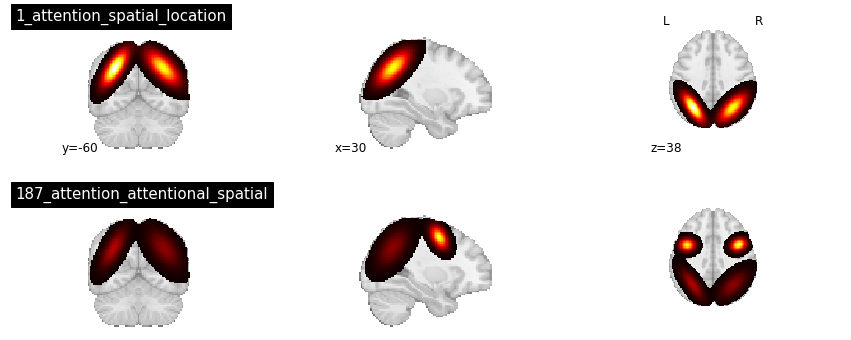

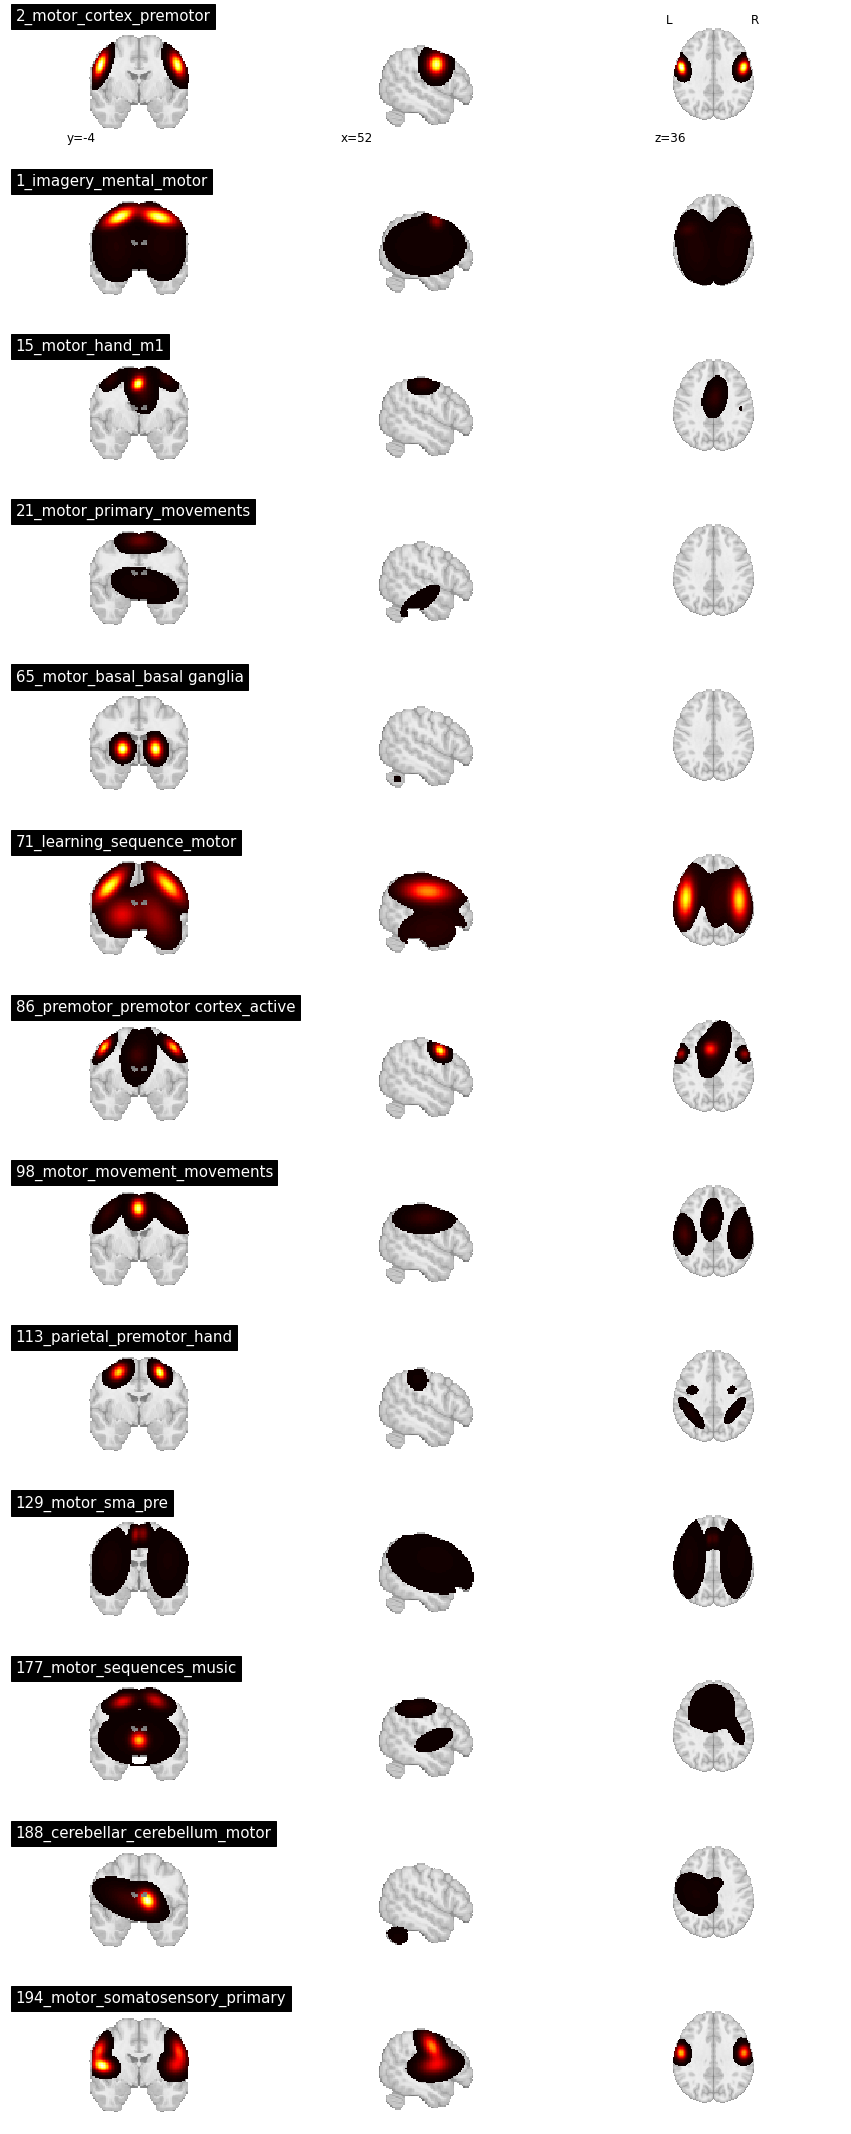

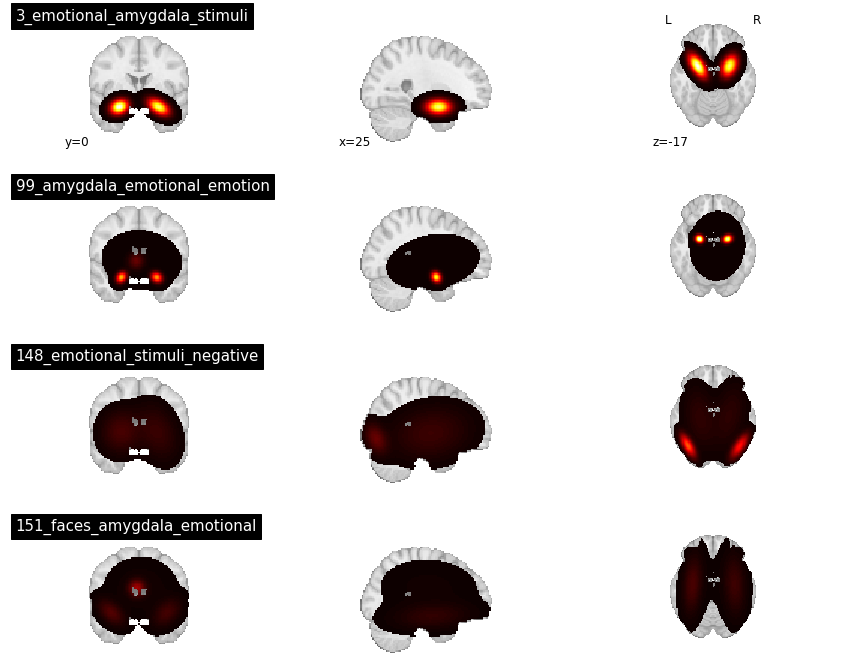

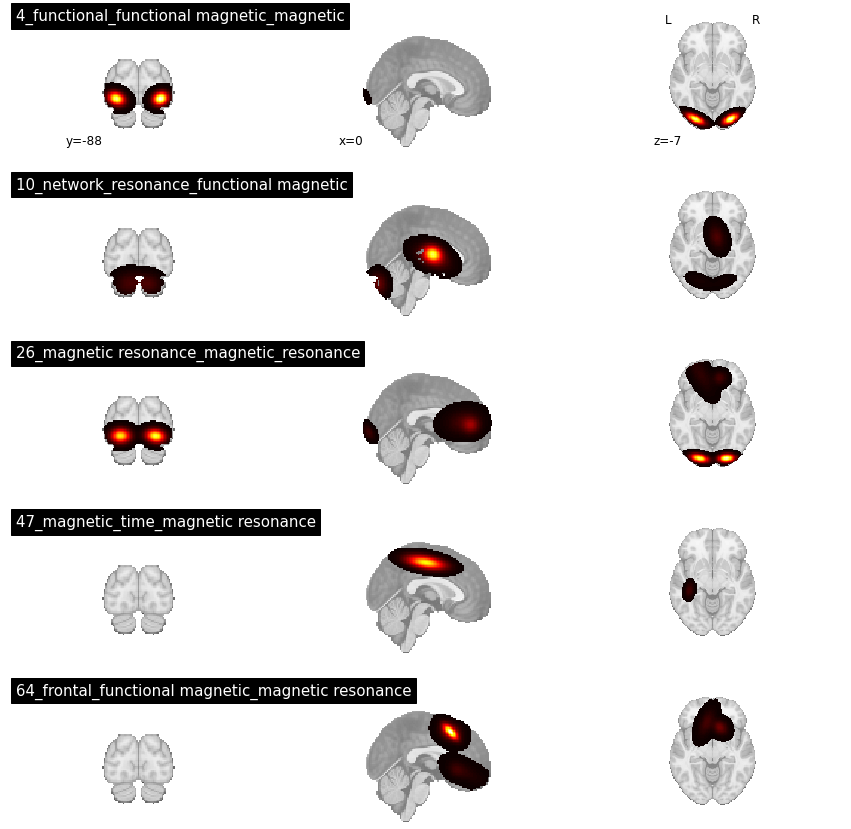

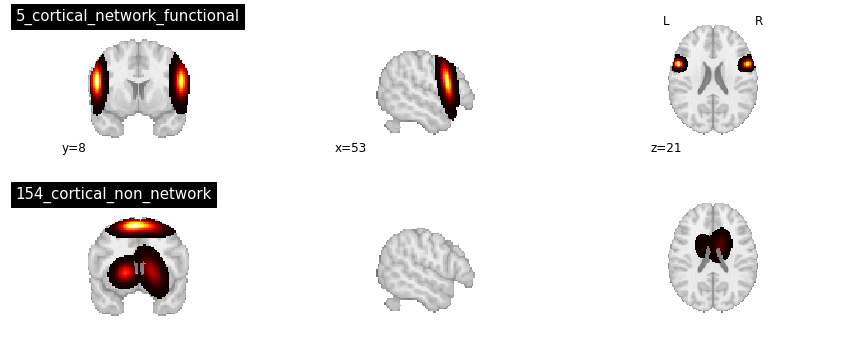

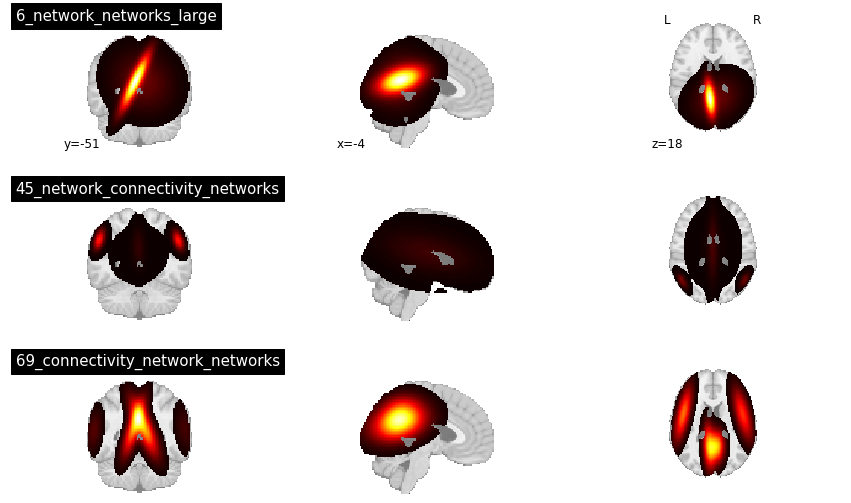

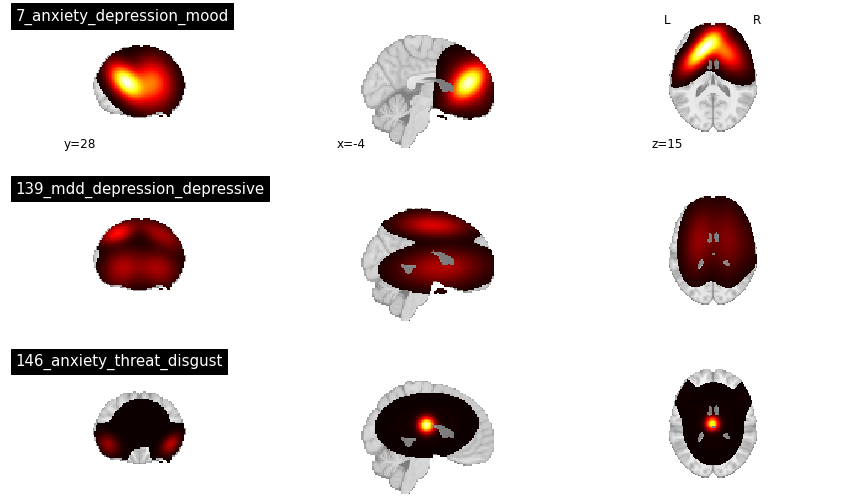

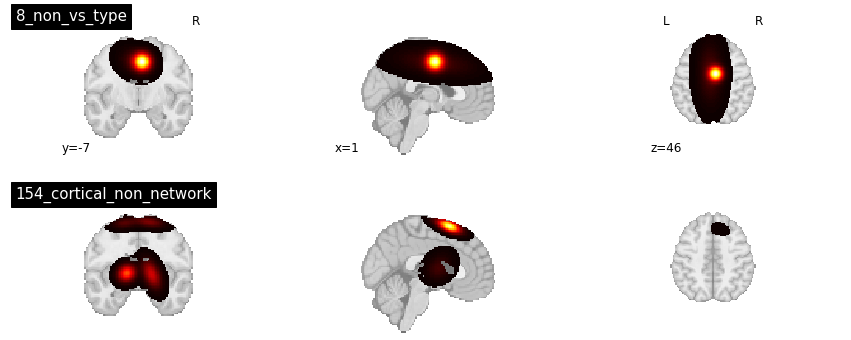

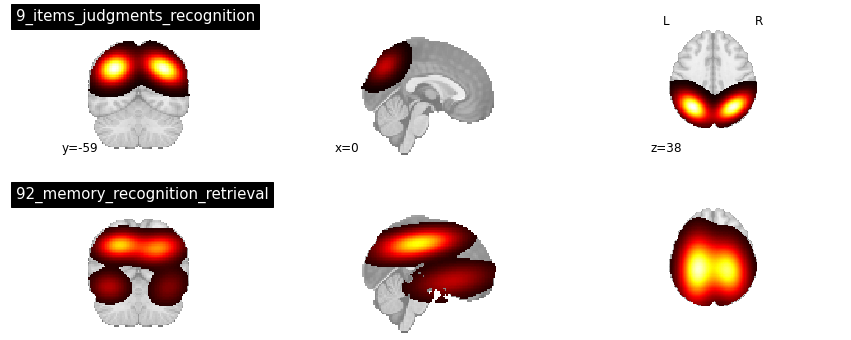

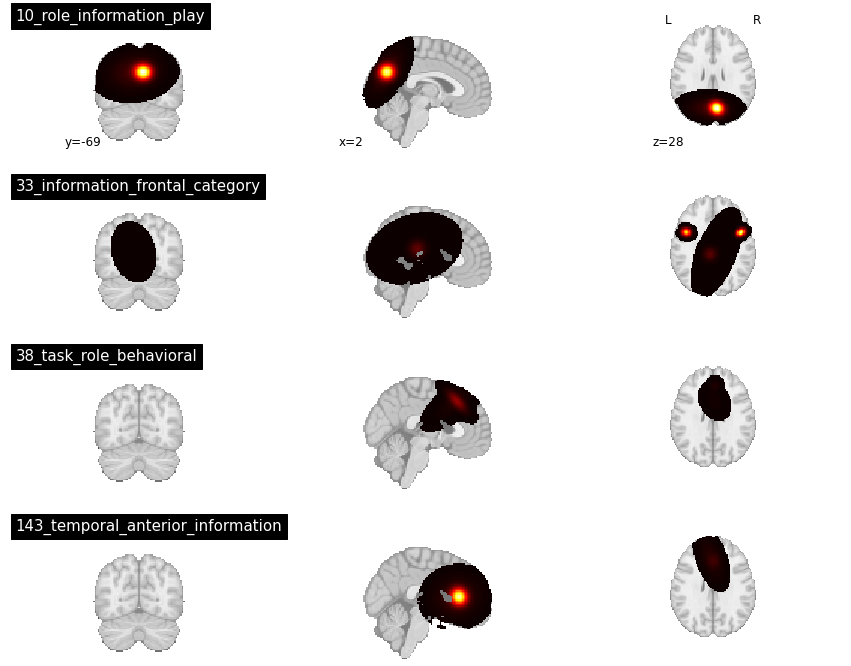

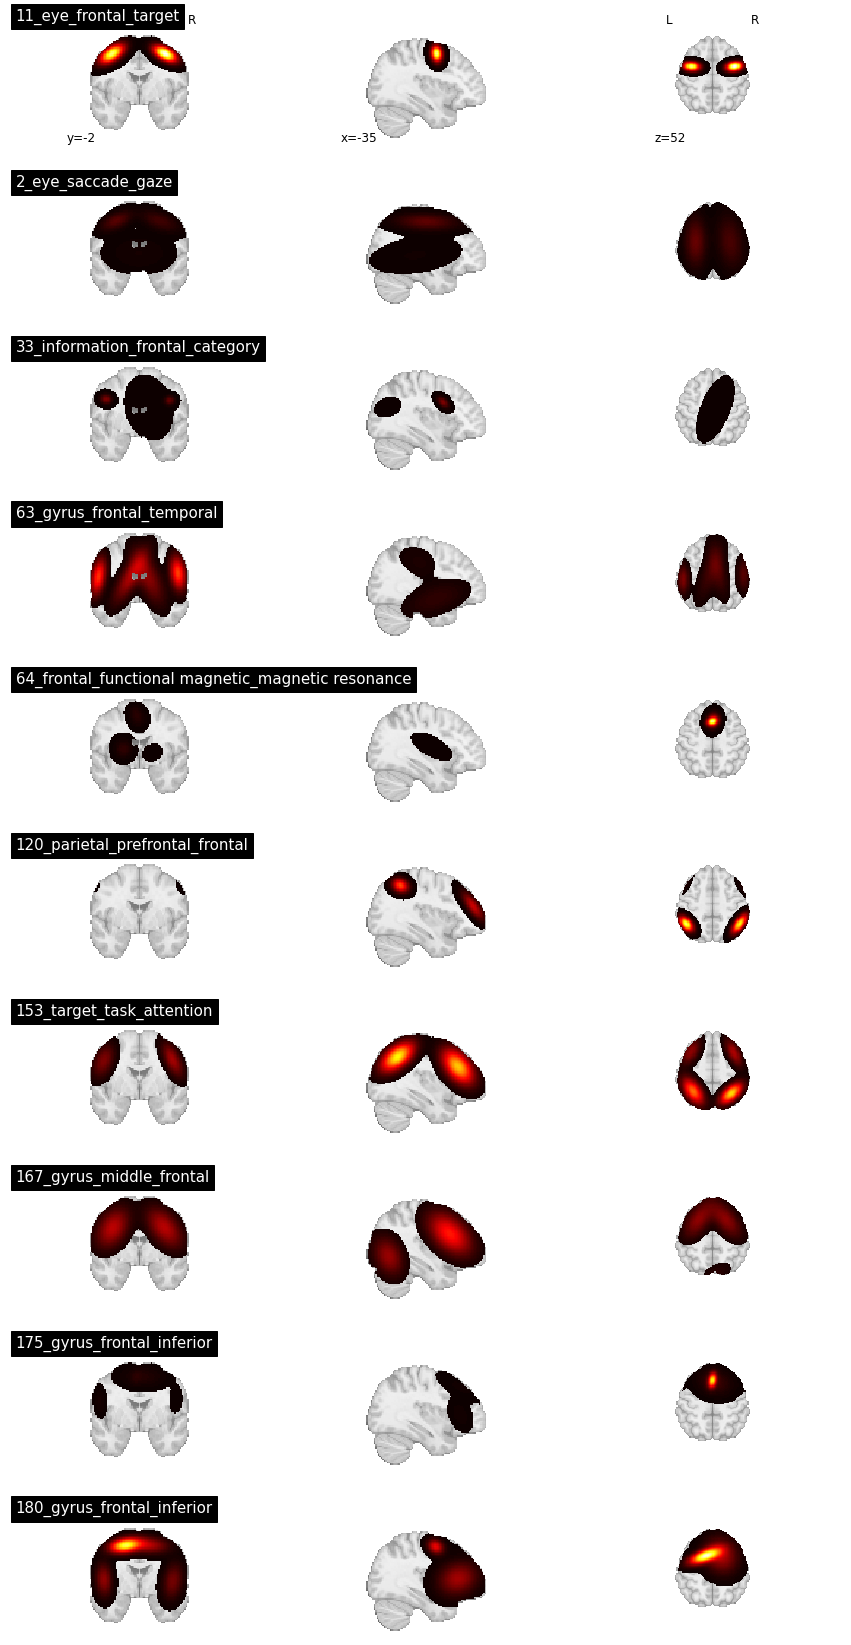

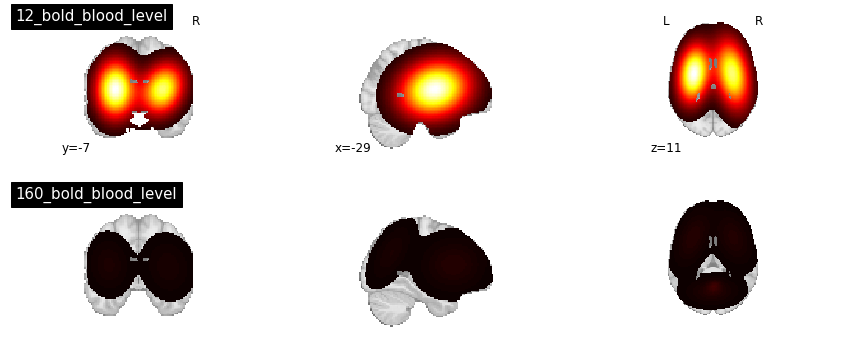

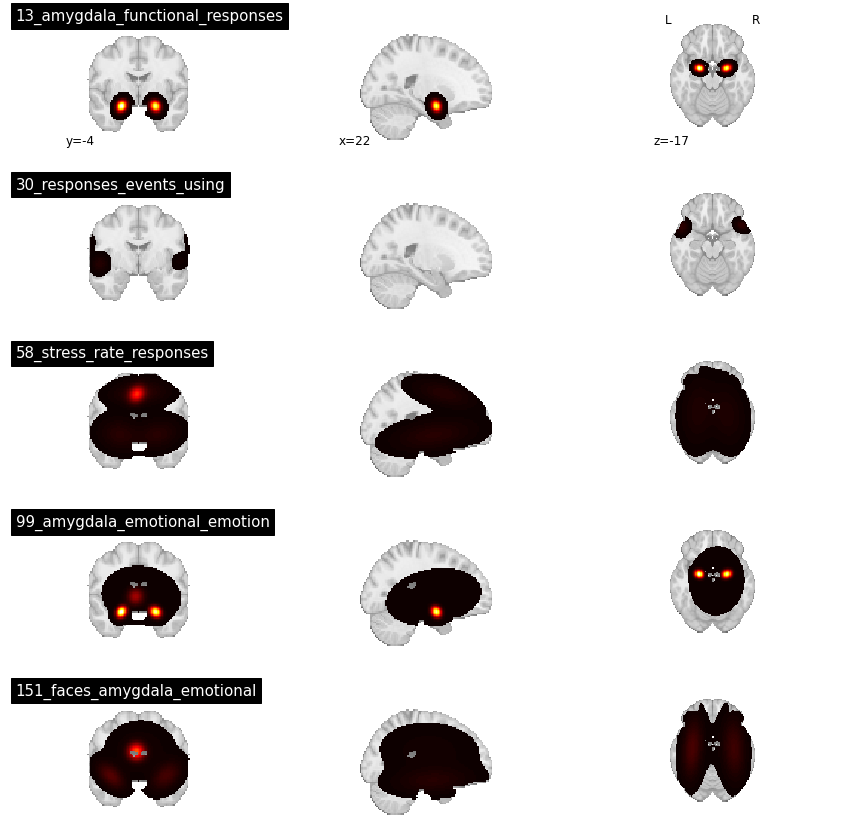

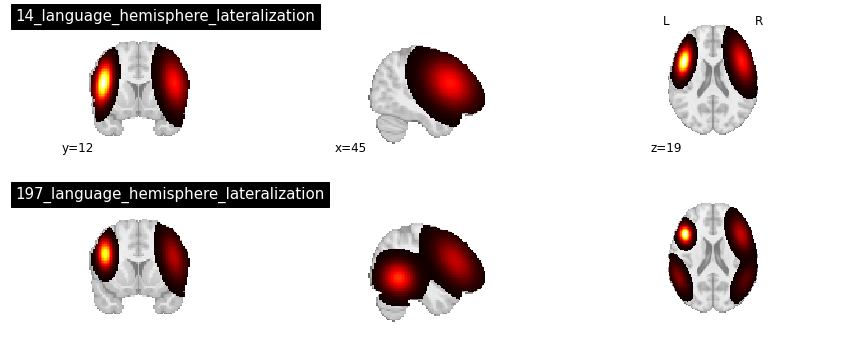

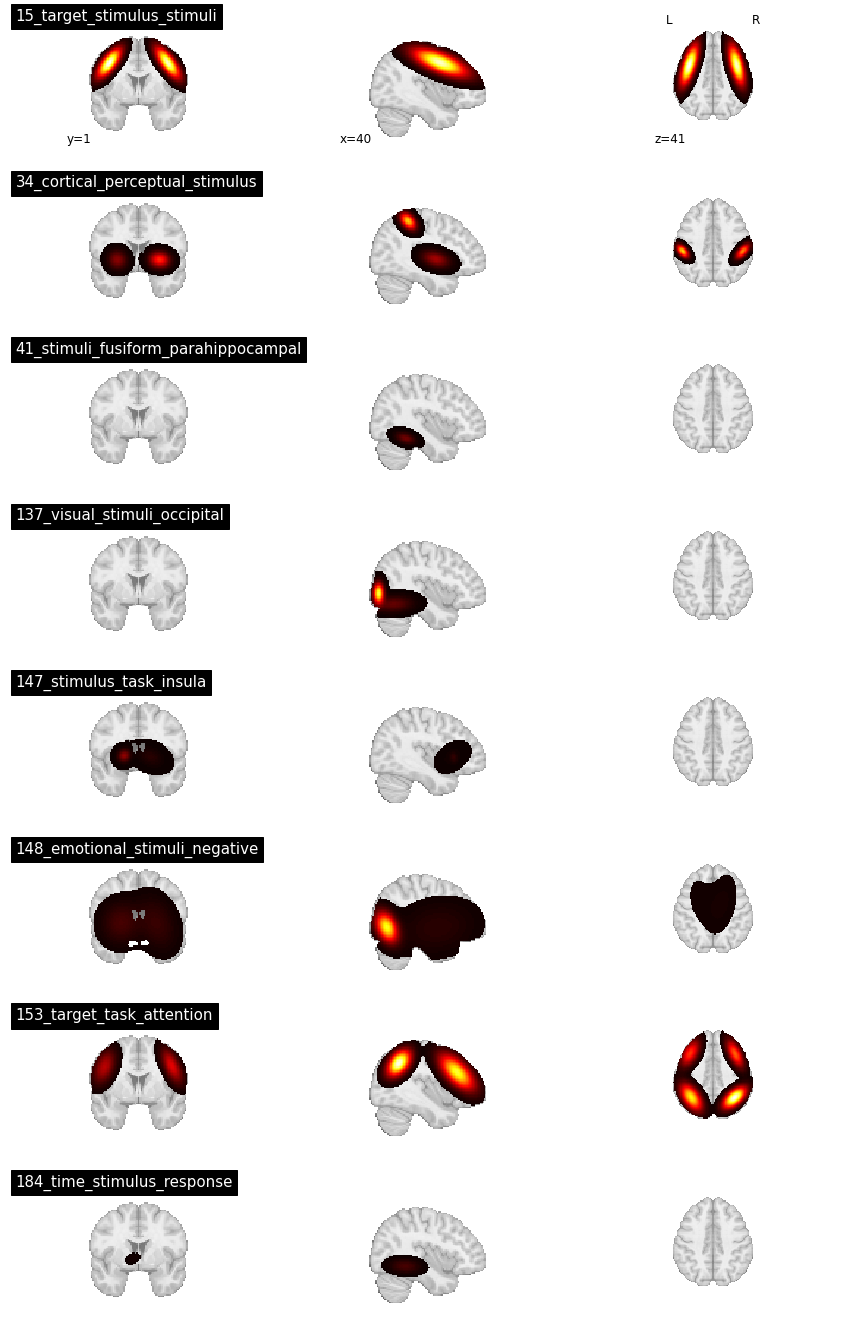

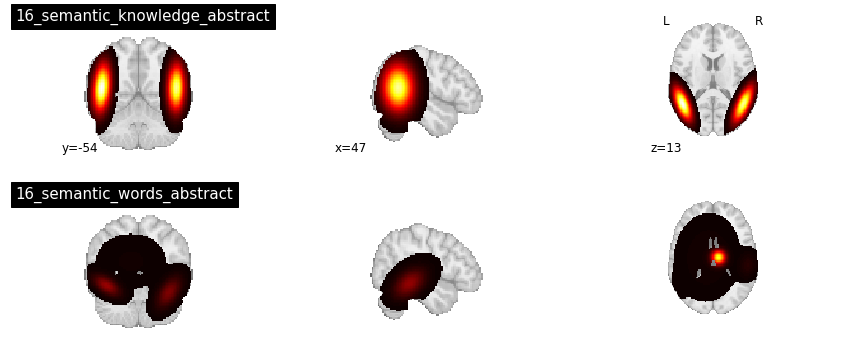

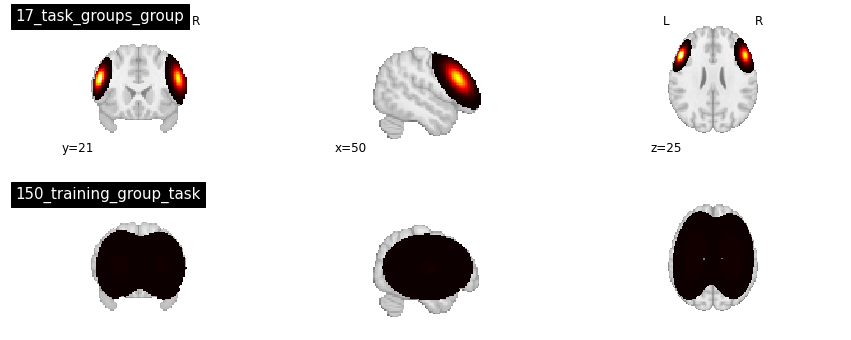

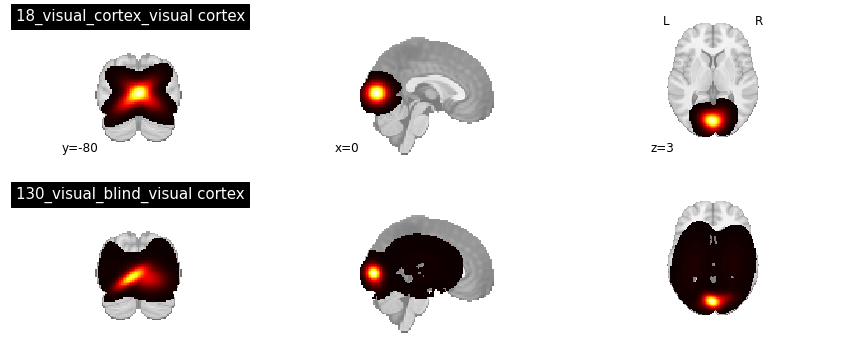

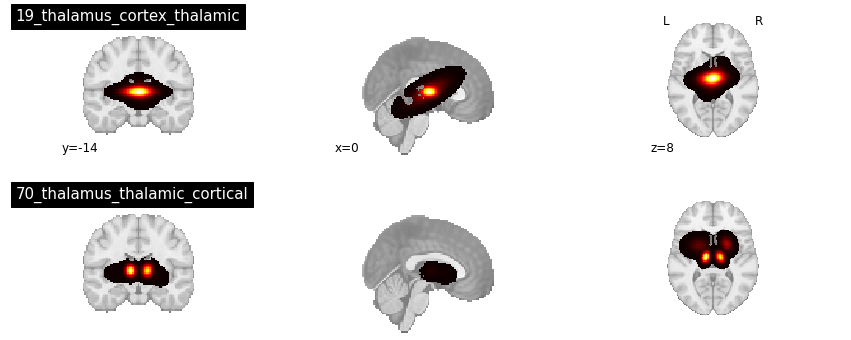

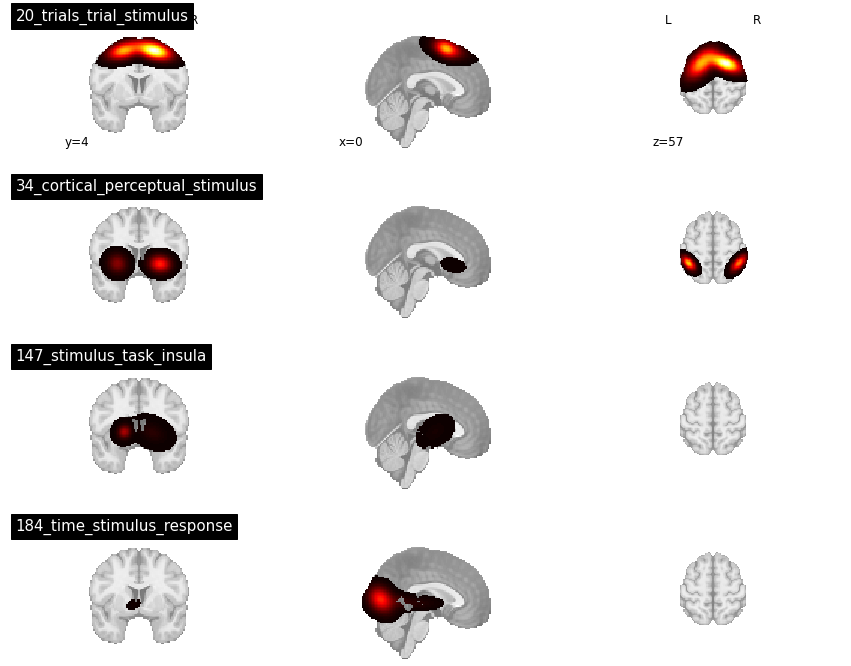

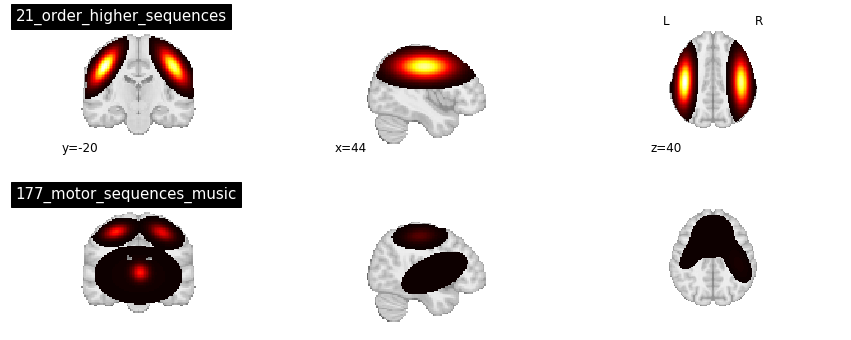

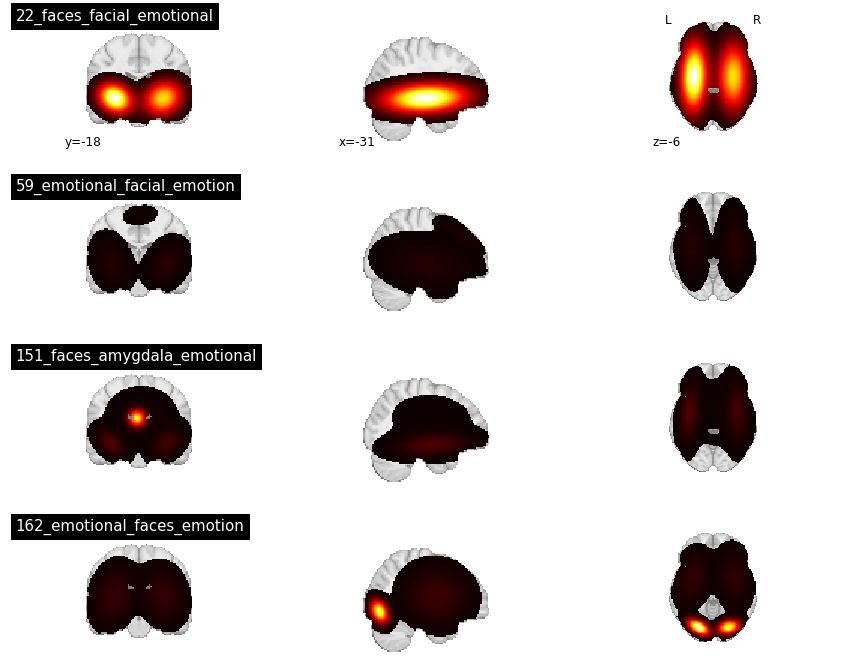

KeyboardInterrupt: 

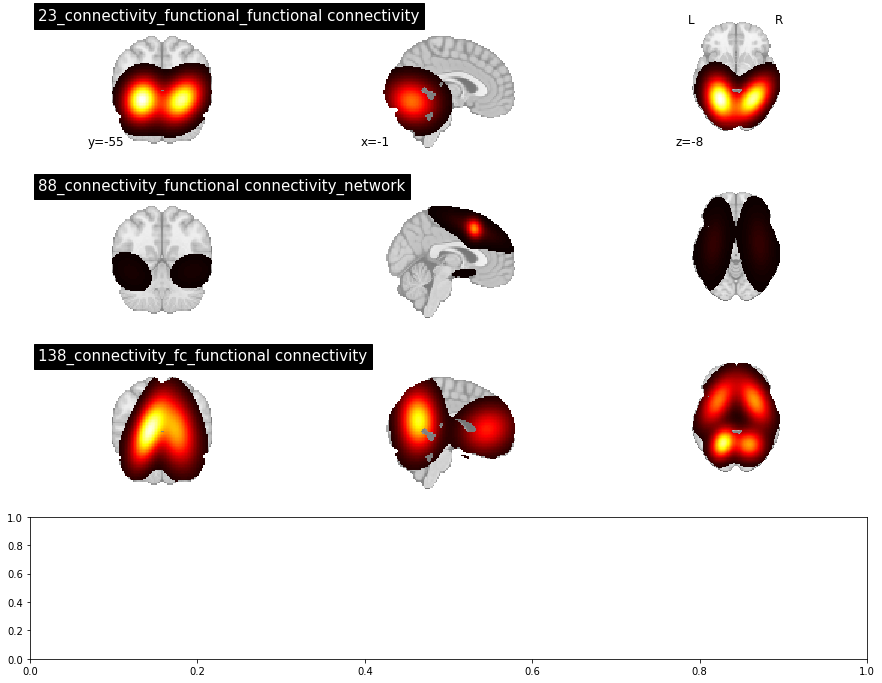

In [6]:
plot_topic_assc(topics_matched, old_meta_maps_imgs, old_features, new_meta_maps_imgs, new_features)